# San Francisco v2

The goal of this notebook was to explore predicting AQI with tweets using LSA or Glove word embeddings and different models.

****

#### Experiment 1: Predicting AQI with individual tweets

#### Experiment 2: Predicting AQI with tweets grouped by day  

#### Experiment 3: Predicting (classifying) AQI outliers by tweets grouped by day

#### Experiment 4: Predicting AQI by tweets using word embeddings

****



In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame
import utils as ut

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

In [2]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

health_df = concat_data('../data/san_francisco/')
health_df.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_14084/1640379659.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon
0,968999128641323008,25624940,@Volker_E Am I hallucinating that you are walk...,{'place_id': '5a110d312052166f'},2018-02-28 23:59:30,37.708075,-122.514926
1,968999100757680128,8888,There’s just something weird about living in N...,{'place_id': '5ef5b7f391e30aff'},2018-02-28 23:59:23,37.845953,-122.324818
2,968999065273774080,1557223812,Tomorrow’s March sheeeesh I’m basically 24 😕 t...,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:14,37.592632,-122.160814
3,968999056537088000,1164993320,Wednesday really be draining 6-6 school day 😴,{'place_id': '5ecbd073f39c00fa'},2018-02-28 23:59:12,37.592632,-122.160814
4,968999038493245440,18650764,@remedy415 @Brycesavoy510 This hella dope,{'place_id': 'ab2f2fac83aa388d'},2018-02-28 23:59:08,37.699279,-122.342660


In [3]:
# Turn into a TwitterDataFrame and zoom in on san francisco
health_df = TwitterDataFrame(health_df)
lat = (37, 39)
lon = (-121, -124)
sf_df_raw = health_df.zoom_in(lat, lon)

In [4]:
# Take a random subsample of the dataframe to reduce the size
sf_df_raw = sf_df_raw.sample(50000, replace=True).reset_index(drop=True)

# Ideally this should be before sampling but this way saves time
# Could this happen in TwitterDataFrame?
sf_df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in sf_df_raw['created_at']]

# Subset 5/2018-12/2018
sf_df_raw = sf_df_raw[sf_df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
sf_df_raw['date'] = sf_df_raw['created_at'].dt.floor('d')

sf_df = TwitterDataFrame(sf_df_raw)
sf_df.head()

,id,author_id,text,geo,created_at,lat,lon,date
0,1024169091362222080,92624305,@feliciamizbiz He told me no haha I already ha...,{'place_id': '5a110d312052166f'},2018-07-31 05:45:14,37.708075,-122.514926,2018-07-31
1,1017423794024034309,54950914,@geekmagnifique I was 21 and just starting out...,{'place_id': '5a110d312052166f'},2018-07-12 15:01:49,37.708075,-122.514926,2018-07-12
3,1018534312080130055,23398334,@Palaye_Royale_A I Really Enjoy @PalayeRoyale ...,{'place_id': 'ab2f2fac83aa388d'},2018-07-15 16:34:38,37.699279,-122.342660,2018-07-15
4,1057483965433430021,114679758,Carmelo making the Rockets a lottery team is g...,{'place_id': 'a35b62af9d82aa08'},2018-10-31 04:06:39,37.842368,-122.100030,2018-10-31
6,1003405645486231552,15030165,I get such a sense of accomplishment any time ...,{'place_id': '866269c983527d5a'},2018-06-03 22:38:42,37.759330,-122.457782,2018-06-03


In [51]:
# What are the basics of this data set?
print("Lenth: ", len(sf_df))
print("Per day :", len(sf_df)/365)

Lenth:  40211
Per day : 110.16712328767123


Text(0.5, 0, 'Date')

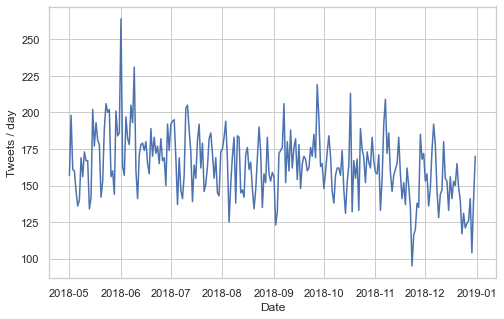

In [52]:
# Plot num tweets per day by date
plt.figure(figsize=(8,5))
plt.plot(sf_df.count_by_day())
ax = plt.gca()
ax.set_ylabel("Tweets / day")
ax.set_xlabel("Date")

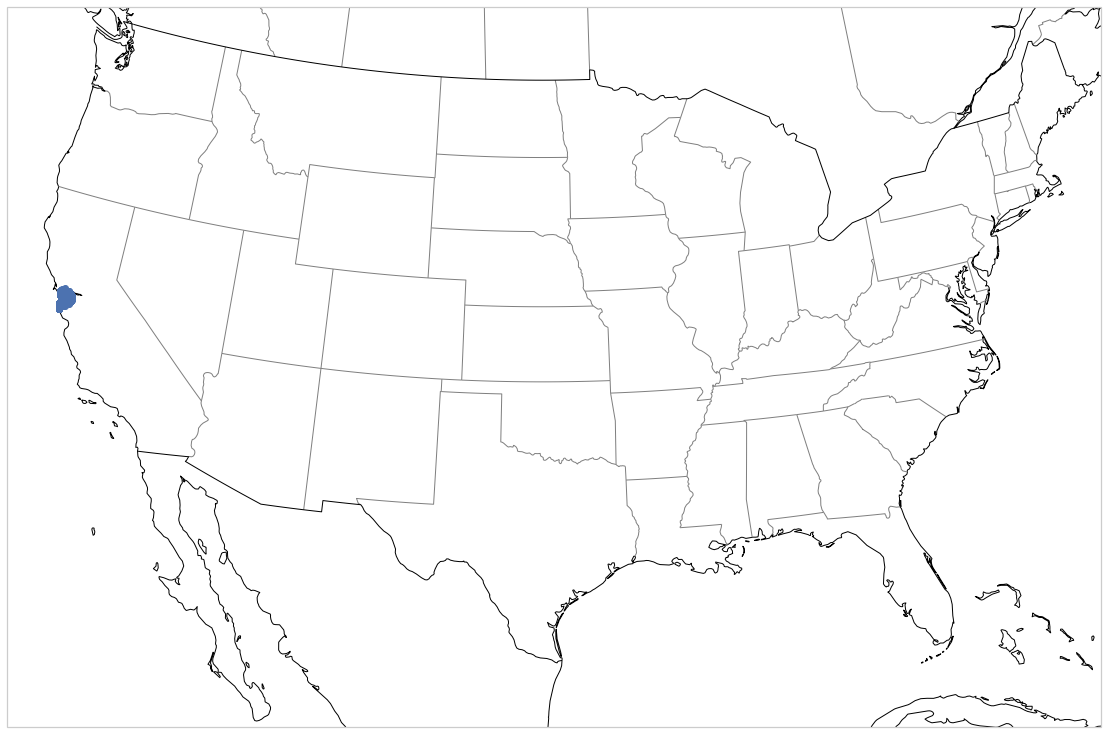

In [53]:
import cartopy
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection=cartopy.crs.LambertConformal(central_longitude=-98.0))
ax.set_extent((-120, -75,21, 50), cartopy.crs.Geodetic())
ax.coastlines()

# Add state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS)
ax.scatter(sf_df['lon'],sf_df['lat'], transform=cartopy.crs.PlateCarree())
# plt.show()

In [54]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

# Subset just SF country and extract dates
sf_aqi = aqi_2018[(aqi_2018['State Name']=='California') & (aqi_2018['county Name']=='San Francisco')]
sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])

sf_aqi.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_4252/2893133138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_aqi['Date'] = pd.to_datetime(sf_aqi['Date'])


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
27443,California,San Francisco,6,75,2018-01-01,72,Moderate,PM2.5,06-075-0005,1
27444,California,San Francisco,6,75,2018-01-02,82,Moderate,PM2.5,06-075-0005,1
27445,California,San Francisco,6,75,2018-01-03,111,Unhealthy for Sensitive Groups,PM2.5,06-075-0005,1
27446,California,San Francisco,6,75,2018-01-04,58,Moderate,PM2.5,06-075-0005,1
27447,California,San Francisco,6,75,2018-01-05,26,Good,NO2,06-075-0005,1


</br>
</br>
</br>

## Experiment 1: Predicting AQI with individual tweets
----

In [71]:
# Merge AQI and tweet dateframes
sf_mrg = pd.merge(left=sf_df, right=sf_aqi, left_on='date', right_on='Date', how='inner')

# extract our regression variables
X = sf_mrg['text']
y = sf_mrg['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

sf_mrg.head()

,id,author_id,text,geo,created_at,lat,lon,date,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,1008382298306166784,577268396,California has a $9B surplus. No trickle down.,{'place_id': '6890a27317bf4a9b'},2018-06-17 16:14:09,37.827626,-122.067214,2018-06-17,California,San Francisco,6,75,2018-06-17,30,Good,Ozone,06-075-0005,1
1,1008441410461159424,314221793,@SHO_DyingUpHere @billburr DON'T OPEN THE DOOR...,{'place_id': '5a110d312052166f'},2018-06-17 20:09:02,37.708075,-122.514926,2018-06-17,California,San Francisco,6,75,2018-06-17,30,Good,Ozone,06-075-0005,1
2,1008187258560606208,322910657,@CarlosElizondo5 You’re wild,{'place_id': 'ab2f2fac83aa388d'},2018-06-17 03:19:08,37.699279,-122.342660,2018-06-17,California,San Francisco,6,75,2018-06-17,30,Good,Ozone,06-075-0005,1
3,1008214575215403008,415348260,@RowdyGurl18 G-a-r-b-a-g-e,{'place_id': '5358b6f78dd95ef6'},2018-06-17 05:07:41,37.600909,-122.473595,2018-06-17,California,San Francisco,6,75,2018-06-17,30,Good,Ozone,06-075-0005,1
4,1008246377271287808,187059363,@raybyers1 @realDonaldTrump But you are a bot ...,{'place_id': '6890a27317bf4a9b'},2018-06-17 07:14:03,37.827626,-122.067214,2018-06-17,California,San Francisco,6,75,2018-06-17,30,Good,Ozone,06-075-0005,1


In [72]:
X_train.shape, y_train.shape

((32168,), (32168,))

In [73]:
# Text regression pipeline
def train_model(X_train, y_train, X_test, y_test, params=(100, 5)):
    n_dim, k = params

    # Vectorize tweets
    # TODO: more data cleaning, lemmetization, etc
    tf_vect = TfidfVectorizer(min_df=1, stop_words="english").fit(X_train)
    X_enc = tf_vect.transform(X_train)
    X_test_enc = tf_vect.transform(X_test)

    # Run trunvated SVD on the vector encodings
    svd_model = TruncatedSVD(n_components=n_dim, n_iter=4, random_state=23).fit(X_enc)
    X_lsa = svd_model.transform(X_enc)
    X_test_lsa = svd_model.transform(X_test_enc)

    # Fit Regression model
    knn_model = KNeighborsRegressor(n_neighbors=k, n_jobs=-1, algorithm='kd_tree').fit(X_lsa, y_train)
    y_pred = knn_model.predict(X_lsa)

    return svd_model, knn_model, X_lsa, y_pred, X_test_lsa


In [58]:
svd_model, knn_model, X_lsa, y_pred, X_test_lsa = train_model(X_train, y_train, X_test, y_test)
X_lsa.shape, knn_model.score(X_lsa, y_train)

((32168, 100), 0.20501661749352518)

Text(0.5, 1.0, 'First Two Dimensions of SVD Encoding')

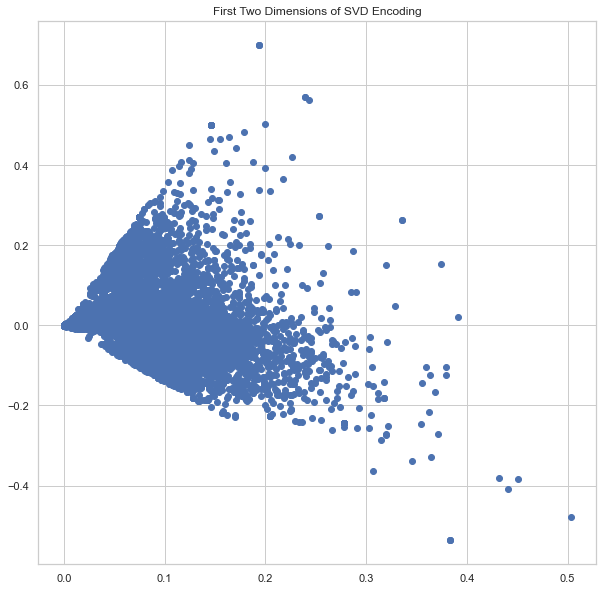

In [74]:
# Scatter the results
plt.scatter(X_lsa[:, 0], X_lsa[:, 1])
plt.title("First Two Dimensions of SVD Encoding")

Text(0.5, 0, 'Low Dimension tweet')

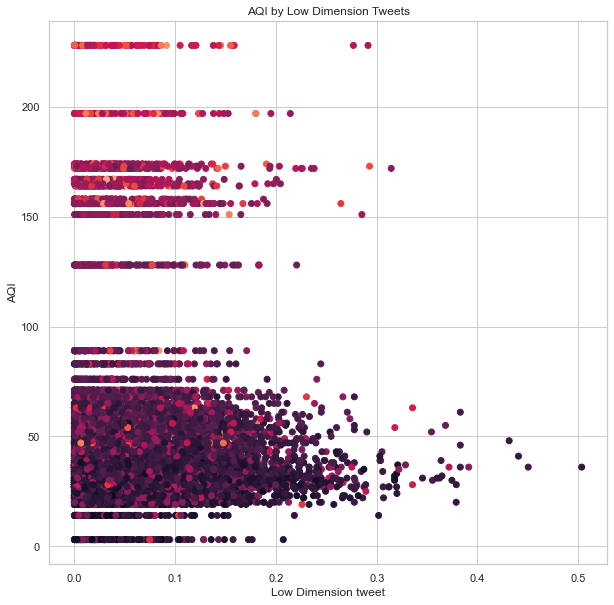

In [76]:
# plot scatterplot and linear model using predictions
plt.scatter(X_lsa[:, 0], y_train, c=y_pred)

plt.title("AQI by Low Dimension Tweets")
plt.ylabel("AQI", fontsize = 12)
plt.xlabel("Low Dimension tweet", fontsize = 12)

In [85]:
# print 5 tweets that predict the highest AQI
max_pred_aqi_idx = np.argpartition(y_pred, -5)[-5:]

for idx in max_pred_aqi_idx:
    print(X_train[idx])

I have to go to work for 2 hours tomorrow for sum stupid training. Ugh I’m mad
But I can’t say anything.
Even after uninstalling the CS6 installer just plain doesn’t work. I looked online and the fix (really!) is launch it from the command line. Yup.

130 billion dollar company. Installer doesn’t work.
“At our wedding we have to write our vowels” -Dante Tupac Ruiz
.@SecPompeo has sold his soul to @realDonaldTrump There is no redemption at this point. #Complicit #JamalKhasoggi  #HumanRights #MagnitskyAct #PutinsPuppet #UnfitToBePresident #UnfitForOffice


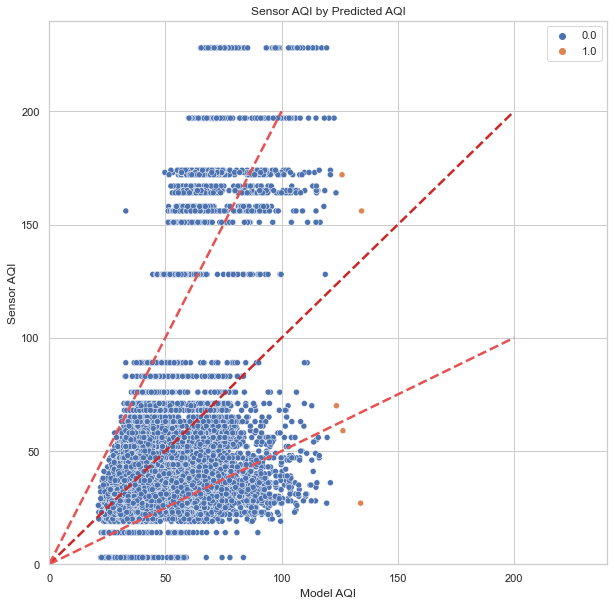

In [84]:
# Plots predictions by their true value
def plot_reference(y_pred, y_train):
    temp = np.zeros_like(y_pred)
    for idx in max_pred_aqi_idx:
        temp[idx] = 1
    plot = sns.scatterplot(x=y_pred, y=y_train, hue=temp)

    # Draw reference lines
    X = np.linspace(0, 200, 200)
    plt.plot(X, X, '--', color="#cc2727", linewidth=2.5)
    plt.plot(X, X/2, '--', color="#e85151", linewidth=2.5)
    plt.plot(X/2, X, '--', color="#e85151", linewidth=2.5)

    # Set plot style
    plot.set(ylim=(0, 240))
    plot.set(xlim=(0,240))

    plot.set_title("Sensor AQI by Predicted AQI")
    plot.set_ylabel("Sensor AQI", fontsize = 12)
    plot.set_xlabel("Model AQI", fontsize = 12)

plot_reference(y_pred, y_train)

</br>
</br>
</br>

## Experiment 2: Predicting AQI with tweets grouped by day  
----

In [ ]:
# Group tweets by day before merging
sf_df_days = sf_df.group_by_day()

# Merge AQI and tweet dateframes
sf_mrg_days = pd.merge(left=sf_df_days, right=sf_aqi, left_on='date', right_on='Date', how='inner')

# extract our regression variables
X_days = sf_mrg_days['text']
y_days = sf_mrg_days['AQI']

X_train_days, X_test_days, y_train_days, y_test_days = train_test_split(X_days, y_days, test_size=0.2, random_state=23)

sf_mrg_days.head()

,text,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,@ThatBabyIsGone It should also be noted that A...,California,San Francisco,6,75,2018-05-01,37,Good,Ozone,06-075-0005,1
1,@rositabella415 It was my mom's idea! @BlancaV...,California,San Francisco,6,75,2018-05-02,36,Good,Ozone,06-075-0005,1
2,@longballgirl Bradley or Boxberger unavailable...,California,San Francisco,6,75,2018-05-03,36,Good,Ozone,06-075-0005,1
3,@brettbuddin I’m still trying to get in contac...,California,San Francisco,6,75,2018-05-04,33,Good,Ozone,06-075-0005,1
4,"Well, I now understand all of the #InfinityWar...",California,San Francisco,6,75,2018-05-05,37,Good,Ozone,06-075-0005,1


In [ ]:
X_train_days.shape, y_train_days.shape

((196,), (196,))

In [ ]:
svd_model_days, knn_model_days, X_lsa_days, y_pred_days, X_test_lsa_days = train_model(X_train_days, y_train_days, X_test_days, y_test_days, (10000, 5))
X_lsa_days.shape, knn_model_days.score(X_lsa_days, y_train_days)

test
test


((196, 196), 0.4754814229313643)

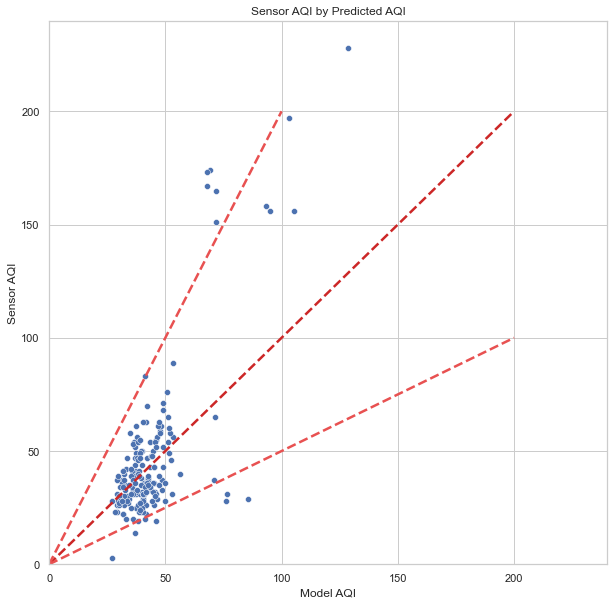

In [ ]:
plot_reference(y_pred_days, y_train_days)

</br>
</br>
</br>

## Experiment 3: Predicting (classifying) AQI outliers by tweets grouped by day
----

In [ ]:
X_test_days.shape, X_test_lsa_days.shape, y_test_days.shape

((49,), (49, 196), (49,))

In [ ]:
y_train_clf = y_train_days > 100
y_test_clf = y_test_days > 100

# Oversample outliers
X_lsa_days_over = np.concatenate((X_lsa_days, X_lsa_days[y_train_clf]))
y_train_clf_over = np.concatenate((y_train_clf, y_train_clf[y_train_clf]))

In [ ]:
# Use random forest model to predict high aqi days
model_clf = RandomForestClassifier().fit(X_lsa_days_over, y_train_clf_over)
y_test_clf_pred = model_clf.predict(X_test_lsa_days)

model_clf.score(X_test_lsa_days, y_test_clf)

0.9387755102040817

Text(0.5, 0, 'Sample num')

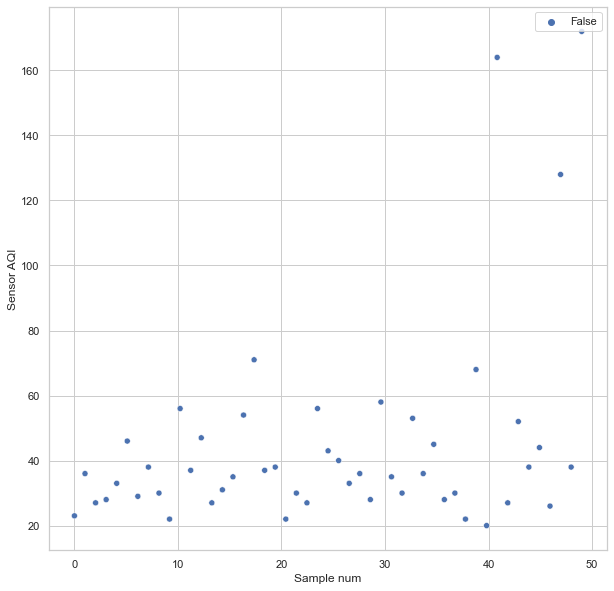

In [ ]:
X = np.linspace(0, y_test_days.shape[0], y_test_days.shape[0])
plot = sns.scatterplot(x=X, y=y_test_days, hue=y_test_clf_pred)

plot.set_ylabel("Sensor AQI", fontsize = 12)
plot.set_xlabel("Sample num", fontsize = 12)


</br>
</br>
</br>

## Experiment 4: Predicting AQI by tweets using word embeddings
----

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras import layers

In [ ]:
X_train_days.shape, X_test_days.shape, y_train_days.shape, y_test_days.shape

((196,), (49,), (196,), (49,))

In [ ]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('../data/glove.twitter.27B.100d.txt')
emb_size = 100 # glove vectors are 100 dim

1193514 words loaded


In [ ]:
# first we convert the twitter text to word indices
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train_days)
word_index = tokenizer.word_index

In [ ]:
# we want to import the vectors of Glove into the embedding_layer using
# embedding_amtrix which has a  shape of (10000, 100)
embedding_matrix = np.zeros((max_words, emb_size)) 
# we loop whole vocabulary of the imdb reviews
for word, i in word_index.items():
    # if the token is smaller than the threshold we set at import
    if i < max_words:
        # we try to get the corresponding embedding from glove
        embedding_vector = glove.get(word) 
        # if this embedding exists, we feed it into our embedding_layer matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will all be zeros

In [ ]:
cnn_model = Sequential()
cnn_model.add(layers.Embedding(max_words, emb_size))
cnn_model.add(layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 5, activation='relu'))
cnn_model.add(layers.GlobalAveragePooling1D())
cnn_model.add(layers.Dense(32, activation = "relu"))
cnn_model.add(layers.Dense(1, activation="linear")) 
cnn_model.summary()

cnn_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# we load our GloVe model into the embedding layer
cnn_model.layers[0].set_weights([embedding_matrix])
# the GloVe embedding is not changed by the training
cnn_model.layers[0].trainable = False 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
history = cnn_model.fit(X_train_days, y_train_days, 
                    epochs=2,
                    batch_size=1, 
                    validation_data=(X_test_days, y_test_days))

Epoch 1/2


ValueError: in user code:

    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\keras\layers\convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\ops\nn_ops.py:1131 convolution_v2
        return convolution_internal(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\ops\nn_ops.py:1261 convolution_internal
        return op(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\util\deprecation.py:617 new_func
        return func(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\util\deprecation.py:617 new_func
        return func(*args, **kwargs)
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\ops\nn_ops.py:2003 conv1d
        result = gen_nn_ops.conv2d(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Nick\miniconda3\envs\bergin\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/conv1d/ExpandDims, sequential/conv1d/conv1d/ExpandDims_1)' with input shapes: [1,1,1,100], [1,5,100,128].


In [ ]:
score = cnn_model.evaluate(X_test_days, y_test, verbose=0)
print('Test accuracy: {:.4}'.format(score[1]))

## Conclusions

#### Review

- Random twitter data is super noisy, very few tweets relate to our topic
- LSA, small-batch cnn probably don't weigh them enough
    - i.e. to dim-reduce input data we are removing the features we are looking for
- Oversampling doesn't seem to work very well even in simple clf
- That said, regression is surprisingly effective

#### Ideas

- Topic modeling seems like a good idea to give us a way to remove noisy samples
- 